In [1]:
from random import Random
from numpy import *
from time import *
from datetime import *
from BlackScholes import *
import math
import scipy as sp

import matplotlib.pyplot as plt
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel, RBF


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [75]:
KC = 130
KP = 70
r = 0.002
sigma = 0.4
T = 2.0
S0 = 100

In [76]:
lb = 0
ub = 300
training_number = 100
testing_number = 50
sigma_n = 1e-8 # additive noise in GP

call = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[0]
put = lambda x,y: bsformula(-1, lb+(ub-lb)*x, KP, r, T, y, 0)[0]

# delta

In [92]:
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call(x_train[idx], sigma))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
f_prime = np.dot(k_s_prime, alpha_p)/(ub-lb)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [93]:
delta = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[1]
delta(x_test, sigma) - f_prime

array([[ 5.15855935e-04],
       [-1.34288746e-04],
       [-3.05667265e-05],
       [ 7.05299766e-05],
       [ 2.44792957e-06],
       [-4.43955564e-05],
       [-1.05854746e-04],
       [ 1.00694076e-04],
       [-4.90654813e-05],
       [-9.84482620e-06],
       [-3.78251312e-05],
       [ 5.25530291e-05],
       [-4.12638997e-05],
       [-4.01937920e-05],
       [-7.40243285e-05],
       [ 1.92046870e-06],
       [-9.89021800e-05],
       [-8.37079729e-05],
       [-6.25125020e-05],
       [-7.01787474e-05],
       [-1.21821870e-04],
       [-1.33624748e-04],
       [-1.69113927e-04],
       [-2.15436074e-04],
       [-2.05152242e-04],
       [-1.98017573e-04],
       [-2.39196166e-04],
       [-2.45872795e-04],
       [-2.32607079e-04],
       [-3.42411685e-04],
       [-2.41748770e-04],
       [-1.94863962e-04],
       [-3.14308691e-04],
       [-2.80376538e-04],
       [-3.10219629e-04],
       [-3.97140603e-04],
       [-4.17973243e-04],
       [-2.15127224e-04],
       [-5.3

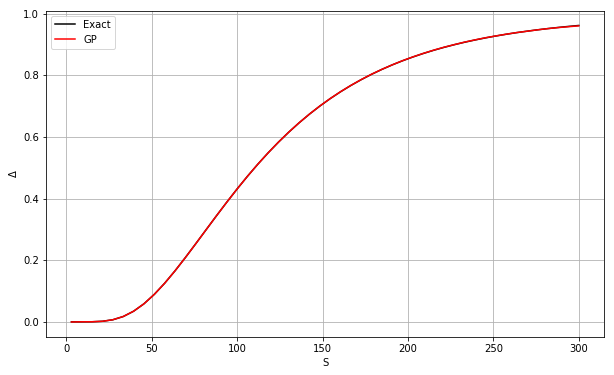

In [99]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma), color = 'black', label = 'Exact')
plt.plot(lb+(ub-lb)*x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('$\Delta$')
plt.legend(loc = 'best', prop={'size':10})

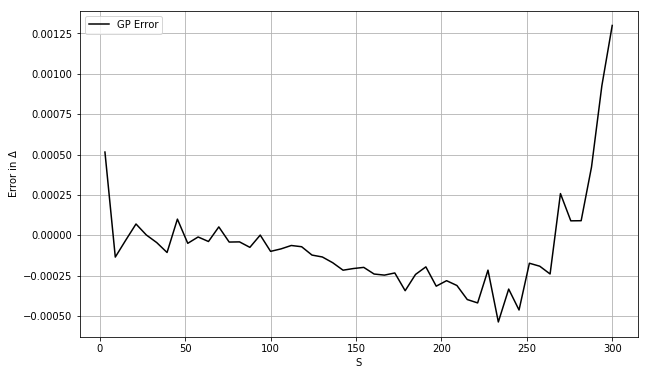

In [101]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(lb+(ub-lb)*x_test, delta(x_test,sigma) - f_prime, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('S')
plt.ylabel('Error in $\Delta$')
plt.legend(loc = 'best', prop={'size':10})

## vega

In [82]:
x_train = np.array(np.linspace(0.01,1.2, training_number), dtype='float32').reshape(training_number, 1)
x_test = np.array(np.linspace(0.01,1.0, testing_number), dtype='float32').reshape(testing_number, 1)

y_train = []
    
for idx in range(len(x_train)):
    y_train.append(call((S0-lb)/(ub-lb), x_train[idx]))
y_train = np.array(y_train)

sk_kernel = RBF(length_scale=1.0, length_scale_bounds=(0.01, 10000.0)) #+ WhiteKernel(noise_level = 1e-12) #100000.0
gp = gaussian_process.GaussianProcessRegressor(kernel=sk_kernel, n_restarts_optimizer=20)
gp.fit(x_train,y_train)
y_pred, sigma_hat = gp.predict(x_test, return_std=True)
    
l = gp.kernel_.length_scale
rbf= gaussian_process.kernels.RBF(length_scale=l)
 
Kernel= rbf(x_train, x_train)
K_y = Kernel + np.eye(training_number) * sigma_n
L = sp.linalg.cho_factor(K_y)
alpha_p = sp.linalg.cho_solve(np.transpose(L), y_train)
    
k_s = rbf(x_test, x_train)

k_s_prime = np.zeros([len(x_test), len(x_train)])
for i in range(len(x_test)):
    for j in range(len(x_train)):
        k_s_prime[i,j]=(1.0/l**2)*(x_train[j]-x_test[i])*k_s[i,j]
        
f_prime = np.dot(k_s_prime, alpha_p)

/Users/matthewdixon/anaconda3/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:357: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [83]:
vega = lambda x,y: bsformula(1, lb+(ub-lb)*x, KC, r, T, y, 0)[2]
vega((S0-lb)/(ub-lb), x_test) - f_prime

array([[-0.03042599],
       [-0.03417824],
       [ 0.04813572],
       [-0.02066425],
       [ 0.00078639],
       [-0.02449945],
       [-0.00979741],
       [ 0.00720845],
       [-0.00084125],
       [-0.00923278],
       [ 0.02570014],
       [-0.01109279],
       [-0.00459649],
       [-0.01045877],
       [-0.00890098],
       [-0.0122505 ],
       [-0.00843964],
       [-0.00497917],
       [-0.01303292],
       [-0.00153103],
       [ 0.00095914],
       [ 0.00080953],
       [ 0.00808772],
       [ 0.00748916],
       [ 0.00914164],
       [ 0.00981196],
       [ 0.00930099],
       [ 0.00777037],
       [ 0.00491814],
       [ 0.00155685],
       [-0.00102143],
       [-0.00163249],
       [-0.00316678],
       [ 0.00079119],
       [ 0.00363495],
       [ 0.0017962 ],
       [ 0.00741908],
       [ 0.00859901],
       [ 0.00773113],
       [ 0.01086757],
       [ 0.0114922 ],
       [ 0.01150779],
       [ 0.00659299],
       [-0.00650103],
       [-0.0189475 ],
       [-0

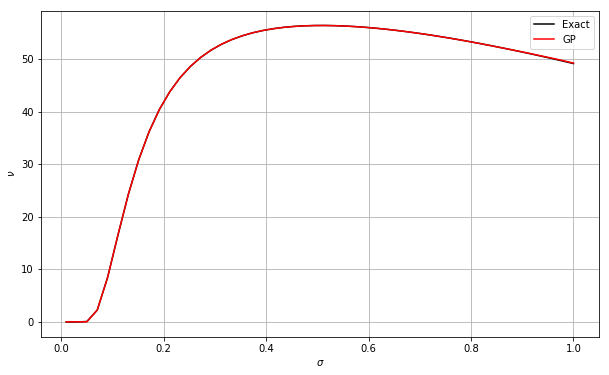

In [90]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test), color = 'black', label = 'Exact')
plt.plot(x_test, f_prime, color = 'red', label = 'GP')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('$\\nu$')
plt.legend(loc = 'best', prop={'size':10})

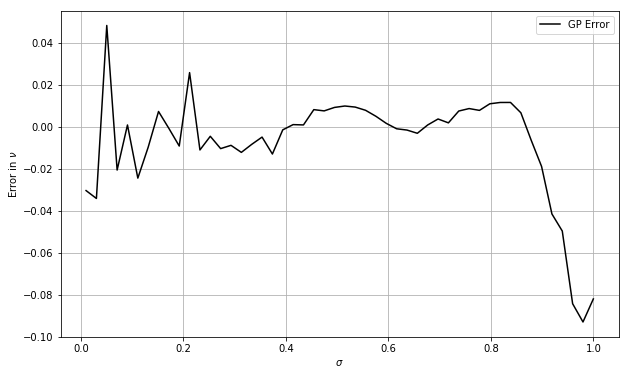

In [91]:
plt.figure(figsize = (10,6),facecolor='white', edgecolor='black')
plt.plot(x_test, vega((S0-lb)/(ub-lb), x_test)-f_prime, color = 'black', label = 'GP Error')
plt.grid(True)
plt.xlabel('$\\sigma$')
plt.ylabel('Error in $\\nu$')
plt.legend(loc = 'best', prop={'size':10})